This scripts allow us to understand if the classes in data.py work or not

In [1]:
seed = 123
import sys
from pathlib import Path
from typing import *
import shutil
import time
import pandas as pd
import pickle
import torch
import numpy as np
import os
from torch.utils.data import random_split, Subset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

sys.path.insert(0, "..")
from dataset.data import (
    RNADataset,
    ROOT_DIR,
    EasyPosAugment,
    RegionSpecNegAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    plot_sample,
    #plot_sample2,
    seed_everything,
    MAX_RNA_SIZE,
)

In [2]:
pos_width_multipliers = {20:0.5, MAX_RNA_SIZE: 0.5}
pos_height_multipliers = pos_width_multipliers
neg_width_windows = {
    (50, 1000): 0.5,
    (1000, MAX_RNA_SIZE): 0.5,
}
neg_height_windows = neg_width_windows

In [3]:
ROOT_DIR = os.path.dirname(os.path.abspath('.'))
original_files_dir = os.path.join(ROOT_DIR, "dataset", "original_files")
processed_files_dir = os.path.join(ROOT_DIR, "dataset", "processed_files")
rna_rna_files_dir = os.path.join(ROOT_DIR, "dataset", "rna_rna_pairs")

In [4]:
l1 = []
l2 = []
_SUBSET_SIZE: int = 1
seed_everything(seed)
for policy in (
    EasyPosAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_width_multipliers,
        height_multipliers=pos_height_multipliers,
    ),
    # EasyNegAugment(
    #     per_sample=1,
    #     width_windows=neg_width_windows,
    #     height_windows=neg_height_windows,
    # ),
    # HardPosAugment(
    #     per_sample=1,
    #     interaction_selection=InteractionSelectionPolicy.RANDOM_ONE,
    #     min_width_overlap=0.3,
    #     min_height_overlap=0.3,
    #     width_multipliers=pos_width_multipliers,
    #     height_multipliers=pos_height_multipliers,
    # ),
    # HardNegAugment(
    #     per_sample=1,
    #     width_windows=neg_width_windows,
    #     height_windows=neg_height_windows,
    # ),
    # RegionSpecNegAugment(
    #     per_sample=1,
    #     width_windows=pos_width_multipliers,
    #     height_windows=neg_height_windows,
    # ),
):
    start_time = time.time()

    dataset = RNADataset(
        gene_info_path=os.path.join(processed_files_dir, "df_genes.csv"),
        interactions_path=os.path.join(
            processed_files_dir, "final_df.csv"
        ),
        subset_file=os.path.join(
            rna_rna_files_dir, "gene_pairs_val.txt"
        ),
        augment_policies=[
            policy,
        ],
    )
    for i, sample in tqdm(enumerate(dataset)):
        l1.append(sample.bbox.x2 - sample.bbox.x1)
        l2.append(sample.bbox.y2 - sample.bbox.y1)
        if i == 3:
            break
        #print(sample.gene1, sample.gene2)
        continue

TypeError: RNADataset.__init__() got an unexpected keyword argument 'gene_info_path'

In [20]:
len(sample.gene1_info["cdna"])

2198

In [21]:
len(sample.gene2_info["cdna"])

3155

In [22]:
sample.bbox

BBOX(x1=0, x2=2198, y1=0, y2=3155)

/data01/gbini/projects/RNA-RNA/src/../dataset/data.py:1188: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot([0, width],[0, height], 'ro', color = 'white')


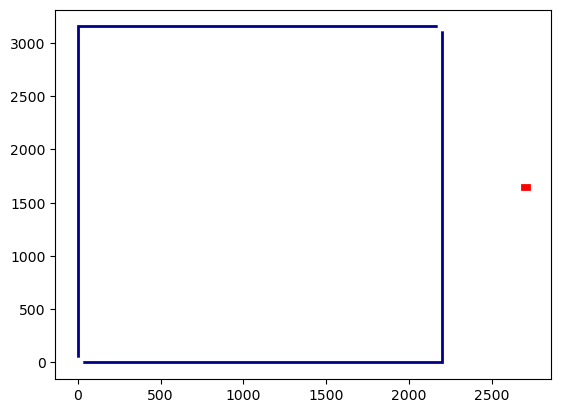

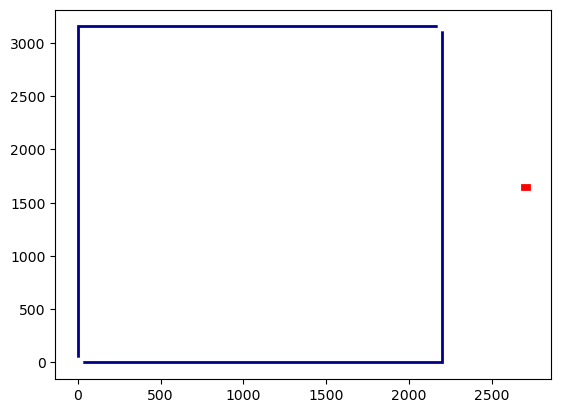

In [23]:
plot_sample(sample)

In [ ]:
df_genes = pd.read_csv(
    os.path.join(processed_files_dir, "df_genes.csv"), sep=","
)

# Check if classes works

In [31]:
df = pd.read_csv(
    os.path.join(processed_files_dir, "df_annotation_files_cleaned.csv"), sep=","
)
with open(os.path.join(rna_rna_files_dir, "gene_pairs_training_random_filtered.txt"), "rb") as fp:  # Unpickling
                subset = pickle.load(fp)
# with open(os.path.join(rna_rna_files_dir, "gene_pairs_test_random_filtered.txt"), "rb") as fp:  # Unpickling
#                 subset = pickle.load(fp)
# with open(os.path.join(rna_rna_files_dir, "gene_pairs_val_random_filtered.txt"), "rb") as fp:  # Unpickling
#                 subset = pickle.load(fp)
df = df[df.couples.isin(subset)]

### Check if RegionSpecificNeg works

In [6]:
d = {}
idx = 0
for i, sample in tqdm(enumerate(dataset)):
    assert len(sample.all_couple_interactions) == 1
    assert sample.all_couple_interactions[0]['interacting'] == False
    couple = sample.all_couple_interactions[0]['couple']
    gene1, gene2 = sample.gene1, sample.gene2
    if gene1 + '_' + gene2 == couple:
        are_swapped = False
    elif gene2 + '_' + gene1 == couple:
        are_swapped = True
    else:
        assert False
    if are_swapped:
        gene1, gene2 = gene2, gene1
        y1, y2, x1, x2 = sample.bbox.coords
    else:
        x1, x2, y1, y2 = sample.bbox.coords
    subset_gene1 = df[(df.gene1 == gene1)|(df.gene2 == gene1)]
    subset_gene1 = subset_gene1[subset_gene1.there_is_interaction == True]
    subset_gene2 = df[(df.gene1 == gene2)|(df.gene2 == gene2)]
    subset_gene2 = subset_gene2[subset_gene2.there_is_interaction == True]
    
    theonlyone = subset_gene1.shape[0]+subset_gene2.shape[0] == 1 
    
    for _, row in subset_gene1.iterrows():
        if row.gene1 == gene1:
            c1, c2 = row.x1, row.x1 + row.w
        elif row.gene2 == gene1:
            c1, c2 = row.y1, row.y1 + row.h
        else:
            assert False
        d[idx]={'gene': gene1,
                'x1':x1,
                'x2':x2,
                'real_interaction_x1': c1,
                'real_interaction_x2': c2,
                'samplegene1': sample.gene1,
                'samplegene2': sample.gene2,
                'theonlyone':theonlyone
               }
        idx+=1

    for _, row in subset_gene2.iterrows():
        if row.gene1 == gene2:
            c1, c2 = row.x1, row.x1 + row.w
        elif row.gene2 == gene2:
            c1, c2 = row.y1, row.y1 + row.h
        else:
            assert False
        d[idx]={'gene': gene2,
                'x1':y1,
                'x2':y2,
                'real_interaction_x1': c1,
                'real_interaction_x2': c2,
                'samplegene1': sample.gene1,
                'samplegene2': sample.gene2,
                'theonlyone':theonlyone
               }
        idx+=1

    #if (sample.gene1 == 'ENSG00000167880')&(sample.gene2 == 'ENSG00000108799'):
    #ENSG00000167880 ENSG00000108799
    # if i == 3:
         #break

0it [00:00, ?it/s]

In [7]:
res = pd.DataFrame.from_dict(d, 'index')
res2 = res[res.theonlyone == False]
res = res[res.theonlyone == True]
assert res[res.x1>res.real_interaction_x1].shape[0] == 0
assert res[res.x2<res.real_interaction_x2].shape[0] == 0
res2 = res2.drop_duplicates().reset_index(drop = True)

Controllo su res2

In [8]:
res2['id'] = res2.samplegene1 + res2.samplegene2
def calc_coords(gene, df):
    subset = df[(df.gene1 == gene)]
    subset = subset[subset.there_is_interaction == True]
    series_x1 = subset.x1
    series_x2 = subset.x1 + subset.w

    subset = df[(df.gene2 == gene)]
    subset = subset[subset.there_is_interaction == True]
    series_y1 = subset.y1
    series_y2 = subset.y1 + subset.h

    coord_x1 = pd.concat([series_x1, series_y1])
    coord_x2 = pd.concat([series_x2, series_y2])
    return coord_x1, coord_x2

In [9]:
all_genes = set(df.gene1).union(df.gene2)
d_genes = {}
for g in tqdm(all_genes):
    d_genes[g] = calc_coords(g, df)

  0%|          | 0/17944 [00:00<?, ?it/s]

In [10]:
#total time gene_pairs_training_random_filtered: 8 min
for idx in tqdm(np.unique(res2['id'])):
    coord_x1, coord_x2 = [], []
    sampled_x1, sampled_x2 = [], []
    subset = res2[res2.id == idx]
    subset['key'] = subset['x1'].astype(str) + '_' + subset['x2'].astype(str)
    subset = subset.drop_duplicates('key')
    for _, row in subset.iterrows():
        c1, c2 = d_genes[row.gene]
        coord_x1.append(c1)
        coord_x2.append(c2)
        sampled_x1 += [row.x1 for i in range(len(c1))]
        sampled_x2 += [row.x2 for i in range(len(c2))]
    coord_x1 = pd.concat(coord_x1).reset_index(drop = True)
    coord_x2 = pd.concat(coord_x2).reset_index(drop = True)
    sampled_x1 = pd.Series(sampled_x1)
    sampled_x2 = pd.Series(sampled_x2)
    assert ((sampled_x1 <= coord_x1)&(sampled_x2 >= coord_x2)).any()

  0%|          | 0/2449 [00:00<?, ?it/s]

/tmp/ipykernel_12073/1821462824.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['key'] = subset['x1'].astype(str) + '_' + subset['x2'].astype(str)


### Check if EasyPos works

In [16]:
d = {}
idx = 0
for i, sample in tqdm(enumerate(dataset)):
    #assert len(sample.all_couple_interactions) == 1
    couple = sample.all_couple_interactions[0]['couple']
    gene1, gene2 = sample.gene1, sample.gene2
    if gene1 + '_' + gene2 == couple:
        are_swapped = False
    elif gene2 + '_' + gene1 == couple:
        are_swapped = True
    else:
        assert False
    if are_swapped:
        gene1, gene2 = gene2, gene1
        y1, y2, x1, x2 = sample.bbox.coords
    else:
        x1, x2, y1, y2 = sample.bbox.coords
    subset = df[(df.gene1 == gene1)&(df.gene2 == gene2)]
    theonlyone = subset.shape[0] == 1
    for _, row in subset.iterrows():
        d[idx]={'gene1': gene1,
                'x1':x1,
                'x2':x2,
                'real_interaction_x1': row.x1,
                'real_interaction_x2': row.x1 + row.w,
                'gene2': gene2,
                'y1':y1,
                'y2':y2,
                'real_interaction_y1': row.y1,
                'real_interaction_y2': row.y1 + row.h,
                'theonlyone':theonlyone
               }
        idx+=1

0it [00:00, ?it/s]

In [17]:
res = pd.DataFrame.from_dict(d, 'index')
res2 = res[res.theonlyone == False]
res = res[res.theonlyone == True]

In [18]:
assert ((res.x1<=res.real_interaction_x1) & 
        (res.x2>=res.real_interaction_x2) & 
        (res.y1<=res.real_interaction_y1) &
        (res.y2>=res.real_interaction_y2)).all()

In [19]:
res2['id'] = res2[['gene1', 'gene2']].agg('_'.join, axis=1)

In [20]:
for idx in tqdm(np.unique(res2['id'])):
    real = df[df.couples == idx]
    assert real.shape[0]>0
    coord_x1, coord_x2 = real.x1, real.x1 + real.w
    coord_y1, coord_y2 = real.y1, real.y1 + real.h
    subset = res2[res2.id == idx]
    for  _, row in subset.iterrows():
        x1, x2, y1, y2 = row.x1, row.x2, row.y1, row.y2
        assert ((x1 <= coord_x1)&(x2 >= coord_x2)&(y1 <= coord_y1)&(y2 >= coord_y2)).any()

  0%|          | 0/1053 [00:00<?, ?it/s]

### Check if HardPos works

In [24]:
d = {}
idx = 0
for i, sample in tqdm(enumerate(dataset)):
    #assert len(sample.all_couple_interactions) == 1
    couple = sample.all_couple_interactions[0]['couple']
    gene1, gene2 = sample.gene1, sample.gene2
    if gene1 + '_' + gene2 == couple:
        are_swapped = False
    elif gene2 + '_' + gene1 == couple:
        are_swapped = True
    else:
        assert False
    if are_swapped:
        gene1, gene2 = gene2, gene1
        y1, y2, x1, x2 = sample.bbox.coords
    else:
        x1, x2, y1, y2 = sample.bbox.coords
    subset = df[(df.gene1 == gene1)&(df.gene2 == gene2)]
    theonlyone = subset.shape[0] == 1
    for _, row in subset.iterrows():
        d[idx]={'gene1': gene1,
                'x1':x1,
                'x2':x2,
                'real_interaction_x1': row.x1,
                'real_interaction_x2': row.x1 + row.w,
                'gene2': gene2,
                'y1':y1,
                'y2':y2,
                'real_interaction_y1': row.y1,
                'real_interaction_y2': row.y1 + row.h,
                'theonlyone':theonlyone
               }
        idx+=1
res = pd.DataFrame.from_dict(d, 'index')
res2 = res[res.theonlyone == False]
res = res[res.theonlyone == True]

0it [00:00, ?it/s]

In [25]:
assert (
    (res.x1<=res.real_interaction_x1)|(res.x2>=res.real_interaction_x2) &
    ((res.y1<=res.real_interaction_y1)|(res.y2>=res.real_interaction_y2))
).all()

### Check if EasyNeg works

In [28]:
d = {}
idx = 0
for i, sample in tqdm(enumerate(dataset)):
    assert len(sample.all_couple_interactions) == 1
    couple = sample.all_couple_interactions[0]['couple']
    subset = df[(df.couples == couple)]
    assert (subset.there_is_interaction == False).all()

0it [00:00, ?it/s]

### Check if HardNeg works

In [32]:
d = {}
idx = 0
for i, sample in tqdm(enumerate(dataset)):
    #assert len(sample.all_couple_interactions) == 1
    couple = sample.all_couple_interactions[0]['couple']
    gene1, gene2 = sample.gene1, sample.gene2
    if gene1 + '_' + gene2 == couple:
        are_swapped = False
    elif gene2 + '_' + gene1 == couple:
        are_swapped = True
    else:
        assert False
    if are_swapped:
        gene1, gene2 = gene2, gene1
        y1, y2, x1, x2 = sample.bbox.coords
    else:
        x1, x2, y1, y2 = sample.bbox.coords
    subset = df[(df.gene1 == gene1)&(df.gene2 == gene2)]
    assert (subset.there_is_interaction == True).all()
    theonlyone = subset.shape[0] == 1
    for _, row in subset.iterrows():
        d[idx]={'gene1': gene1,
                'x1':x1,
                'x2':x2,
                'real_interaction_x1': row.x1,
                'real_interaction_x2': row.x1 + row.w,
                'gene2': gene2,
                'y1':y1,
                'y2':y2,
                'real_interaction_y1': row.y1,
                'real_interaction_y2': row.y1 + row.h,
                'theonlyone':theonlyone
               }
        idx+=1
res = pd.DataFrame.from_dict(d, 'index')
res2 = res[res.theonlyone == False]
res = res[res.theonlyone == True]

0it [00:00, ?it/s]

In [33]:
assert ((res.x2<=res.real_interaction_x1)|(res.x1>=res.real_interaction_x2)|
        (res.y2<=res.real_interaction_y1)|(res.y1>=res.real_interaction_y2)
       ).all()